In [1]:
# The theory is inspired from:
# https://jaketae.github.io/study/word2vec/#forward-propagation

### Word2Vec as defined by Wikipedia:

<b>Word2vec is a technique for natural language processing published in 2013. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.</b>

In [2]:
# importing libraries
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [3]:
# sample text as an input
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

### Tokenization:

<b>A simple method to convert sentences or paragraphs into their granular entity format i.e. words<br>
<i>Example string : "The bottle is on the table"</i><br>

The string gets converted to python list after tokenization.<br>

<i>Tokenized string : ["The", "bottle", "is", "on", "the", "table"]</i></b>

In [4]:
# removing unwanted special characters
text = re.sub(",", "", text)

# Simple tokenization function returns 
def tokenize(text):
    return re.findall(r'[A-Za-z0-9]+', text.lower())

In [5]:
tokens = tokenize(text)
print("Tokens for the input string : \n", set(tokens))

Tokens for the input string : 
 {'mathematical', 'through', 'study', 'a', 'difficult', 'tasks', 'in', 'the', 'as', 'develop', 'seen', 'conventional', 'of', 'applications', 'so', 'data', 'make', 'without', 'computer', 'decisions', 'it', 'being', 'infeasible', 'wide', 'programmed', 'variety', 'is', 'improve', 'build', 'predictions', 'filtering', 'sample', 'known', 'artificial', 'automatically', 'model', 'training', 'or', 'order', 'are', 'based', 'email', 'that', 'subset', 'on', 'machine', 'such', 'do', 'where', 'needed', 'to', 'learning', 'algorithms', 'experience', 'intelligence', 'explicitly', 'used', 'and', 'vision', 'perform'}


<b>As computers cannot process string data, we need a way to convert our string token into numerical format. One such operation is to provide indices to our tokens. therefore we create a map between tokens and indices, and vice versa.</b>

In [6]:
# the function returns proper mapping for tokens
def mapping(tokens):
    id_2_word = {i:j for (i,j) in enumerate(set(tokens))}
    word_2_id = {j:i for (i,j) in id_2_word.items()}
    
    return word_2_id, id_2_word

word_2_id, id_2_word = mapping(tokens)

# the below dictionary contains the key as words 
# and value as its respecive indices.
# the reverse mapping of the same can be used a lookup table,
# to find out the word given its indices
print(word_2_id)

{'mathematical': 0, 'through': 1, 'study': 2, 'a': 3, 'difficult': 4, 'tasks': 5, 'in': 6, 'the': 7, 'as': 8, 'develop': 9, 'seen': 10, 'conventional': 11, 'of': 12, 'applications': 13, 'so': 14, 'data': 15, 'make': 16, 'without': 17, 'computer': 18, 'decisions': 19, 'it': 20, 'being': 21, 'infeasible': 22, 'wide': 23, 'programmed': 24, 'variety': 25, 'is': 26, 'improve': 27, 'build': 28, 'predictions': 29, 'filtering': 30, 'sample': 31, 'known': 32, 'artificial': 33, 'automatically': 34, 'model': 35, 'training': 36, 'or': 37, 'order': 38, 'are': 39, 'based': 40, 'email': 41, 'that': 42, 'subset': 43, 'on': 44, 'machine': 45, 'such': 46, 'do': 47, 'where': 48, 'needed': 49, 'to': 50, 'learning': 51, 'algorithms': 52, 'experience': 53, 'intelligence': 54, 'explicitly': 55, 'used': 56, 'and': 57, 'vision': 58, 'perform': 59}


### Generating Training Data

<b>Word2Vec is a form of supervised learning technique, but we are only given with a paragraph to start with so what could be our features and targets.<br> 

we loop through each word/token in the sentence/corpus. In each loop we look at words at the left and right of the input word(also called as center-word) within a given window called as context words. The left and right words will be paired with the center word to create pairs of words and that will be used as our training data.</b>

<b>Example sentence : <i>"A crazy fox <u>jumped</u> over the cow."</i><br>
For the above sentence, lets consider our window to be 2 and our center-word to be <i>"jumped"</i>.</b>

<b>Therefore, 
our left context words are: <i>["crazy", "fox"]</i><br>
our right context words are: <i>["over", "the"]</i><br>

Our training pairs will come out as:<i><br>
["jumped", "crazy"], <br>
["jumped", "fox"], <br>
["jumped", "over"], <br>
["jumped", "the"] <br></i>

Each word whether it is input word or context word will be represented using One-hot vectors, and our final goal is to create equivalent word embeddings which can show the semantic relationship among the words from corpus.</b>

<b>Below is the code blocks that generates training data using the algorithm described above. we basically iterate over the input paragraph and generate pairs</b

In [7]:
np.random.seed(2021)
        
def one_hot_encode(id, vocab_size):
    """
    return one hot encoded vector for the words
    """
    res = [0] * vocab_size
    res[id] = 1
    return res

In [8]:
def get_pair(word, word_idx, window, sentence):
    #print(word_idx)
    # length of the input sentence
    n_len = len(sentence.strip().split(" "))
    # left word indexes
    left_words = range(max(0, word_idx - window), word_idx)
    # right word indexes
    right_words = range(word_idx, min(n_len, word_idx + window+1))
    
    # consolidating left and right context word indexes
    context_words_idx = list(left_words) + list(right_words)
    try:
        context_words_idx.remove(word_idx)
    except:
        print("excepted  word : ", word_idx)
        
    # collecting all the context words
    context_words = [sentence.strip().split(" ")[i] for i in context_words_idx]
    yield from context_words

def get_training_data(text, window = 2):
    # empty lists for context and center word
    X, y = [], []
    for sentence in text.lower().split("."):
        # stripping of unwanted spaces
        sentence = sentence.strip()
        for idx, word in enumerate(sentence.split(" ")):
            center_word = word
            context_words = get_pair(center_word, idx, window, sentence)
        
            for c_word in context_words:
                X.append(one_hot_encode(word_2_id[c_word], len(word_2_id)))
                y.append(one_hot_encode(word_2_id[center_word],len(word_2_id)))
    
    return np.asarray(X), np.asarray(y)

In [9]:
X, y = get_training_data(text, 2)

In [10]:
# checking the dimensionality of data 
# to get a sense of what matrices we are working with.
print("X : {}, y : {}".format(X.shape, y.shape))

X : (312, 60), y : (312, 60)


<b>Both <i>X</i> and <i>y</i> are matrices with 312 rows and 60 columns. Here, 312 is the number of training examples we have. The number of rows would have been larger if we would have used a larger window. 60 is the size of our corpus, since we have one hot encoded both input and output as 60-dimensional sparse vectors, this is expected.</b>

<b>Now, we are ready to build and train our embedding network</b>

### The Embedding Model

<b>The expected outcome from the word2vec is to generate an embedding for input words which when used with input words will result in the prediction of context words. These embeddings are nothing but rows of the intermediate weight matrices which we get after training our model with intermediate hidden layers and a softmax output layer</b>

<b>For example:</b> 
<b>lets take an example of 3 samples from the corpus denoted as X<sub>3</sub>. X<sub>3</sub> has a shape of (3,60), we take a weight matrix W<sub>1</sub> with the shape (60,2). The dot product of X<sup>T</sup><sub>3</sub> with W<sub>1</sub> results in a matrix with shape of (3,2). The resultant matrix of shape (3,2) is exactly what we want to achieve with embedding: representing words as dense vectors, an increment from simple one hot encoding.</b>

<b>The <a href = "https://jaketae.github.io/study/word2vec/#forward-propagation">post</a> by Jaesung Tae describes the whole idea of embedding in a much more illustrated and detailed manner.</b>

<b>Moving on, we have our data ready for training, but to make sure that our model trains in a good way we would be comparing our results from softmax output that to true one-hot encoded targets. The error function we use with softmax is cross entropy, defined as:</b>
<br><br>
<center><b><i>$H(p,q) = - \sum p(x).log(q(x))$</i></b></center>

<b>The vectors we are dealing with are one-hot encoded therefore if I sum the sum the values of a vector it will always results in 1.</b>

<b>Therefore, we can rewrite the loss function equation as:</b>
<br><br>
<center><b><i>$H(p,q) = - p.log(q)$</i></b></center>

<b>Where <i>p</i> is the true labels and <i>q</i> is the predicted one.</b>

<b>Now, The whole process can be represented in a set of equation which will be used to calculated values in Forward Propagration as well.</b>
<br><br>
<center><i>$X = input(matrix)$</i></center>
<center><i>$A_{1} = X.W_{1}$</i></center>
<center><i>$A_{2} = A_{1}.W_{2}$</i></center>
<center><i>$Z = Softmax(A_{2})$</i></center>

<b>Where $X$ is input, $W_{1}$ and $W_{2}$ are weight matrices and $Z$ is the matrix contains the prediction probability vectors.</b>

### Code Implementation

<b>In the below code we started off with our input size as number of tokens in our training set, In the very first layer the inputs will be converted into the shape of the embedding. On the next layers we are again converting the embedded matrix back into number of tokens, that is because we want our results/embedded matrix to be in similar shape as that of true labels.</b>

In [11]:
def init_network(vocab_size, n_embedding):
    """
    inputs:
    vocab_size : number of tokens in our training set
    n_embedding : the size of embedding we want
    """
    model = {
        "W1" : np.random.randn(vocab_size, n_embedding),
        "W2" : np.random.randn(n_embedding, vocab_size)
    }
    return model

<b>Let's specify our model to create 20-dimensional embeddings. In other words each token now will be converted from 60-dimensions to 20-dimensions. The actual word2vec model used much higher dimensions such as 300, but for our purposes this is not necessary.</b>

In [12]:
model = init_network(len(word_2_id), 20)

# Current state representation of model
model

{'W1': array([[ 1.48860905,  0.67601087, -0.41845137, ..., -0.22508127,
         -1.33620597,  0.30372151],
        [-0.72015884,  2.5449146 ,  1.31729112, ..., -0.16150753,
         -2.79353057,  0.36164801],
        [ 0.24010758,  0.47781228,  0.20885194, ..., -0.67335092,
          1.22222171, -0.92641342],
        ...,
        [ 0.5095208 , -0.35721995, -0.9493845 , ..., -0.15412878,
          0.66883833, -1.34445507],
        [-0.28392442, -1.69575813, -0.37903759, ...,  0.0637477 ,
         -1.54333106,  0.76194403],
        [-0.05690875, -0.49331203,  0.50302151, ...,  0.25543456,
         -1.60934907,  0.15491553]]),
 'W2': array([[-2.14142059, -0.42644362,  3.28832288, ..., -1.24307108,
         -1.18852196,  0.02933298],
        [-0.44975585, -0.65242634,  1.48745667, ..., -1.15040527,
          0.5292788 ,  1.26745163],
        [ 0.33728638,  0.48471877,  0.38711267, ...,  0.48105195,
          0.26199591,  0.45999949],
        ...,
        [-0.21879945, -0.7016483 ,  1.6276

### Forward Propagation

<b>Coding forward propagation is relatively easy as we just need to rewrite the equations from <i>"The Embedding Model"</i> section into code.</b>

In [13]:
def forward(model, X, return_cache = True):
    cache = {}
    cache['A1'] = np.dot(X, model['W1'])
    cache['A2'] = np.dot(cache['A1'], model['W2'])
    cache['Z'] = softmax(cache['A2'])
    
    if not return_cache:
        return cache['Z']
    return cache

<b>For backpropagation, we will need all the intermediate variables, so we hold them in a dictionary called <i>cache</i>. However, if we simply want the final prediction vector only, not the intermediate variables, we set <i>return_cache</i> to <i>False</i>.</b>

<b>For softmax function, we are expecting a matrix instead of a vector as an output from $A_{2}$, so we will need to make some changes accordingly.</b>

In [14]:
def softmax(X):
    z_exp = np.exp(X)
    return z_exp / np.sum(z_exp, axis = 1, keepdims = True)

### Checking the dimensionality

<b>Before moving on we want to test our model and parameters</b>

In [15]:
example_a1 = np.dot(X, model['W1'])
print(example_a1.shape)
example_a2 = np.dot(example_a1, model['W2'])
print(example_a2.shape)
example_z = softmax(example_a2)
print(example_z.shape)

(312, 20)
(312, 60)
(312, 60)


### Backpropagation

<b>In backpropagation we try to find out our derivatives of loss function with respect to our parameters, currently in our case $W_{1}$ and $W_{2}$</b>

<b>Fortunately, we have already calculated the equations which we require for backpropagation in this <a href = "https://github.com/Pi-Akash/Pytorch-Learnings/blob/main/Neural%20Network%20from%20Scratch.ipynb">notebook</a> where we implement neural network from scratch, Calculation of backpropagation is an important step and there are many good resources available in the internet, therefore I am not going to describe how we got to these equations, if you want to learn more about backpropagation, please go through the below links:</b>

- <a href = "https://deepnotes.io/softmax-crossentropy">How to calculate derivative of Cross Entropy Loss when used with Softmax?</a>
- <a href = "http://colah.github.io/posts/2015-08-Backprop/">Calculus on Computational Graphs: Backpropagation</a>
- <a href = "https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b">Yes you should understand backprop by Andrej Karpathy</a>

<b>Ok, lets look at the equations:</b><br>
$del_{3} = Z - y$<br>
$del_{2} = del_{3} * Softmax(A_{2}) * (1 - Softmax(A_{2}))$<br>
$del_{Loss}/del_{w2} = A_{1}^{T} . del_{2}$<br>
$del_{Loss}/del_{w1} = X^{T} . (del_{2} . W_{2}^{T})$

<b>In the below code block we perform a small sanity check to make sure our dimensions are proper as per the above equations</b>

In [16]:
cache = forward(model, X)
del3 = cache['Z'] - y
print("del3 : ", del3.shape)
del2 = del3 * softmax(cache['A2']) * (1 - softmax(cache['A2']))
print("del2 : ", del2.shape)
delW2 = np.dot(cache['A1'].T, del2)
print("delW2 : ", delW2.shape)
delW1 = np.dot(X.T, np.dot(del2, model['W2'].T))
print("delW1 : ", delW1.shape)

del3 :  (312, 60)
del2 :  (312, 60)
delW2 :  (20, 60)
delW1 :  (60, 20)


<b>Now that the dimensions are proper, Lets implement the backpropagation function</b>

In [17]:
def backward(model, X, y, learning_rate = 0.01):
    cache = forward(model, X)
    del3 = cache['Z'] - y
    del2 = del3 * softmax(cache['A2']) * (1 - softmax(cache['A2']))
    delW2 = np.dot(cache['A1'].T, del2)
    delW1 = np.dot(X.T, np.dot(del2, model['W2'].T))
    
    assert delW2.shape == model['W2'].shape, "delW2 is not the same shape as W2"
    assert delW1.shape == model['W1'].shape, "delW1 is not the same shape as W1"
    model['W1'] = model['W1'] - learning_rate * delW1
    model['W2'] = model['W2'] - learning_rate * delW2
    
    return cross_entropy(cache['Z'], y)

<b>As specified above, we will be using log-loss or Cross entropy loss to keep record of the error between our predictions and true labels, the cross entropy loss can be easily implemented as follows.</b>

In [18]:
def cross_entropy(z, y):
    return -1 * np.sum(np.log(z) * y)

<b>We have created all the components required to train a neural network, Just for assurance we are going to list down all the functions we have created.</b>

- <i>init_network(vocab_size, n_embedding) : Initialization of model parameters</i>
- <i>forward(model, X, return_cache = True) : Forward propagation</i>
- <i>softmax(X) : applies softmax on the input value</i>
- <i>backward(model, X, y, learning_rate = 0.01) : Backward propagation</i>
- <i>cross_entropy(z, y) : calculates log loss</i>

<b>Using above functions we will test our model on the training set</b>

In [38]:
n_iter = 1000 # number of iterations to run
learning_rate = 0.05 # learning rate of the model
model = init_network(len(word_2_id), 20) # initialization of model

# looping forward and backward pass for n iterations:
history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

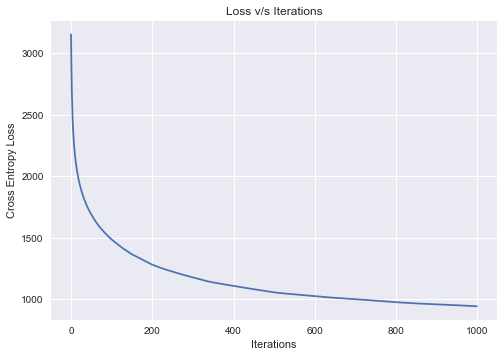

In [39]:
plt.plot(range(len(history)), history)
plt.xlabel("Iterations")
plt.ylabel("Cross Entropy Loss")
plt.title("Loss v/s Iterations")
plt.show()

<b>Looking at the above plot, it seems we did well. The loss starting at a value of 3000+ comes down to less than 1000 after 1000 iterations. we can fiddle with learning rate and number of iterations to get much more fine tuned results to reduce the loss even further. With some degree of confidence we can say that the embedding layer has been trained well.</b>

<b>Lets test our trained model on a word and see what context words we get for the input word.</b>

In [61]:
np.random.seed(2021)
random_word_idx = np.random.randint(len(word_2_id))
print("Random word is : ", id_2_word[random_word_idx])

random_word = one_hot_encode(random_word_idx, len(word_2_id))
result = forward(model, [random_word], return_cache = False)
result = np.squeeze(result)

# printing top 10 words
for word in (id_2_word[id] for id in np.argsort(result)[::-1][:10]):
    print(word)

Random word is :  algorithms
learning
machine
computer
of
improve
used
build
that
develop
conventional


<b>Input text for reference:</b>

<i>Machine learning is the study <b>of computer</b> algorithms <b>that improve</b> automatically through experience. It is seen as a subset of artificial intelligence. Machine learning algorithms build a mathematical model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so. <b>Machine learning</b> algorithms <b>are used</b> in a wide variety of applications, such as email filtering and computer vision, where it is difficult or infeasible to develop conventional algorithms to perform the needed tasks.</i>

<b>We can see that the bold words in the paragraphs are the context words for our input word and out of top 10 predicted words first 4-5 are same as that of highlighted ones. This concludes that our model words as expected.</b>

<b>Now lets look at the embeddings that got created for the training dataset.</b>

In [65]:
print("Embedding shape : ", model['W1'].shape)
print()
print(model['W1'])

Embedding shape :  (60, 20)

[[ 0.03316042 -1.70377684 -0.69516723 ...  0.04795336  0.89781764
  -0.45716584]
 [-0.60903402 -0.50675367 -0.44897499 ...  0.0967588   0.86857157
   0.76617485]
 [-2.58565507 -1.23073185  2.17199634 ...  0.35676115  1.52885652
  -0.9592579 ]
 ...
 [ 0.94002151 -1.20604718  0.14270202 ...  0.89383132  0.74153647
  -0.14949186]
 [-0.35239205  0.35581766 -0.7969699  ... -0.0517016  -0.10718259
   0.03535121]
 [-0.52581913  0.3420522   1.48293876 ...  0.2204532   1.18039095
  -1.65384786]]


<b>Lets make embeddings a little more user friendly for display.</b>

In [70]:
def get_embedding(model, word):
    try:
        idx = word_2_id[word]
    except:
        print("Word not in corpus")
    one_hot = one_hot_encode(idx, len(word_2_id))
    return forward(model, [one_hot])['A1']

In [73]:
np.random.seed(2021)
random_word_idx = np.random.randint(len(word_2_id))
print("Random word is : ", id_2_word[random_word_idx])
print("Embedding shape : ", get_embedding(model, id_2_word[random_word_idx]).shape)
get_embedding(model, id_2_word[random_word_idx])

Random word is :  algorithms
Embedding shape :  (1, 20)


array([[-1.59280032,  0.46352374,  0.42955392, -0.79421328,  0.55034104,
         1.0170684 , -0.07856808, -0.16202304,  0.40609382,  0.38084355,
        -1.27358747, -1.06305941,  0.87758973, -1.21262052,  0.53966545,
         0.05435573,  0.50984065,  0.30313373, -0.69539455,  0.25823635]])

<b>Above we tested a random word from the corpus and got a 20 dimensional vector as expected.</b>

<b>And of course, thisvector is not a collection of some randomly initialized numbers, but a result of training with context data generated through the sliding window algorithm described above.</b>